In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import osmnx as ox
import networkx as nx
from scipy import spatial
from sklearn.cluster import KMeans
import seaborn as sns

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
cal_true_traffics = np.load("cal_true_traffics.npy")
cal_pred_traffics = np.load("cal_pred_traffics.npy")
test_pred_traffics = np.load("test_pred_traffics.npy")

In [4]:
G = ox.graph_from_place("Manhattan, New York City, New York", network_type="drive")

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

edges = ox.graph_to_gdfs(G, nodes=False)
edges["highway"] = edges["highway"].astype(str)
edges.groupby("highway")[["length", "speed_kph", "travel_time"]].mean().round(1)

hwy_speeds = {"residential": 35, "secondary": 50, "tertiary": 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [5]:
k = 10
alpha = 0.05

c_cal_tiled = np.transpose(np.tile(cal_true_traffics, (k, 1, 1)), (1, 0, 2))
c_cal_diff = cal_pred_traffics - c_cal_tiled
c_cal_norms = np.linalg.norm(c_cal_diff, axis=-1)
c_cal_scores = np.min(c_cal_norms, axis=-1)

conformal_quantile = np.quantile(c_cal_scores, q = 1 - alpha)

In [6]:
def get_rps_cc(N_rps, regions_samples):
    total_covered = np.sum([len(region_samples) for region_samples in regions_samples])
    total_rps = 0
    rps = []

    for region_idx, region_samples in enumerate(regions_samples):
        component_prop = len(region_samples) / total_covered
        if region_idx == len(regions_samples) - 1:
            n = N_rps - total_rps
        else:
            n = int(np.round(component_prop * N_rps))
            total_rps += n

        # TODO: should we ensure each connected component is > 1 in the "exact answer"? feels arbitrary but maybe desireable?
        if n > 0:
            kmeans = KMeans(n_clusters=n, random_state=0, n_init="auto").fit(region_samples)
            rps.append(kmeans.cluster_centers_)
    return np.vstack(rps)

def _mullers_sample_from_ball(center, r, N_samples, d):
    u = np.random.normal(0, 1, (N_samples, d))
    norm = np.linalg.norm(u, axis=1)
    radius = np.random.uniform(0, 1, N_samples)**(1/d)
    
    u = r * radius.reshape(-1, 1) * u / norm.reshape(-1, 1)
    u = u + center
    return u

def get_region_samples(test_samples, N_samples):
    k = test_samples.shape[0]
    d = test_samples.shape[-1]
    
    samples = np.zeros((k, N_samples, d))
    voronoi_assignments = np.zeros((k, N_samples))

    # fraction of samples in each ball in the associated voronoi cell
    samples = np.apply_along_axis(_mullers_sample_from_ball, axis=1, arr=test_samples, r=conformal_quantile, N_samples=N_samples, d=d)
    samples = samples.reshape(k, N_samples, 1, -1)
    dist = np.linalg.norm(samples - test_samples, axis=-1)
    voronoi_assignments = np.argmin(dist, axis=-1)
    counts = np.sum(voronoi_assignments == np.arange(k).reshape(-1, 1), axis=1)
    
    samples = np.vstack([samples[k,:count,0,:] for k, count in enumerate(counts)]) # should subsample uniformly for counts but this is equivalent
    
    # create graph
    kdt = spatial.KDTree(samples)
    edges = kdt.query_pairs(2000)
    G = nx.from_edgelist(edges)

    connected_components = list(nx.connected_components(G))        
    region_samples = [samples[np.array(list(connected_component))] 
                      for connected_component in connected_components]
    return region_samples

In [18]:
def viz_attribute(attribute, position, cmap_name, titles, fn):
    nrows = 2
    ncols = 1
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4,12))
    
    # vmin = np.min([np.min(cluster_rp_var) for cluster_rp_var in attribute])
    # vmax = np.max([np.max(cluster_rp_var) for cluster_rp_var in attribute])

    for row_idx in range(nrows):
        nx.set_edge_attributes(G, dict(zip(G.edges, attribute[row_idx])), name="to_viz")
        gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False)
        cmap = sns.color_palette(cmap_name, as_cmap=True)
        gdf_edges.plot(ax=axs[row_idx], cmap=cmap, column="to_viz", legend=False)
        axs[row_idx].set_xticks([])
        axs[row_idx].set_yticks([])
        axs[row_idx].set_xlim([-74.00, -73.925])
        axs[row_idx].set_ylim([40.75, 40.85])
        axs[row_idx].set_title(titles[row_idx])
        
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.tight_layout()
    
    im = plt.gca().get_children()[0]
    
    # ugh, kinda ugly, but whatever
    if position == "right":
        fig.subplots_adjust(right=0.83)
        cax = fig.add_axes([0.85, 0.05, 0.05, 0.9]) 
    else:
        fig.subplots_adjust(left=0.17)
        cax = fig.add_axes([0.10, 0.05, 0.05, 0.9]) 

    cbar = fig.colorbar(im, cax=cax)
    if position == "left":
        cbar.ax.tick_params(labelleft=True, labelright=False)
    plt.savefig(fn, bbox_inches="tight")

In [19]:
N_rps = 4
sample_idx = 53

regions_samples = get_region_samples(test_pred_traffics[sample_idx], N_samples=25)
rps = get_rps_cc(N_rps=N_rps, regions_samples=regions_samples)
print(len(regions_samples))

4


In [20]:
regions_samples = np.vstack(regions_samples)

samples_tiled = np.transpose(np.tile(regions_samples, (rps.shape[0], 1, 1)), (1, 0, 2))
samples_diff = rps - samples_tiled
samples_norm = np.linalg.norm(samples_diff, axis=-1)
samples_clusters = np.argmin(samples_norm, axis=-1)

cluster_rp_vars = []
for samples_cluster_idx in range(N_rps):
    rp_samples = regions_samples[samples_clusters == samples_cluster_idx]
    rp_vars = np.log(np.std(rp_samples, axis=0))
    cluster_rp_vars.append(rp_vars)

In [21]:
regions_samples = np.vstack([regions_samples[0], regions_samples[2]])
cluster_rp_vars = np.vstack([cluster_rp_vars[0], cluster_rp_vars[2]])

In [22]:
fn = "/home/yppatel/csi/taxis/results/path_Box_0.pkl"
with open(fn, "rb") as f:
    box_edge_weights = pickle.load(f)

fn = "/home/yppatel/csi/taxis/results/path_CPO_0.pkl"
with open(fn, "rb") as f:
    ellipsoid_edge_weights = pickle.load(f)

In [23]:
def viz_edge_weight_pair(weight_pair, titles, fn):
    orig = list(G)[8]
    dest = list(G)[4350]

    nrows = 1
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8,8))

    for col_idx in range(ncols):
        ax, title, edge_weights = axs[col_idx], titles[col_idx], weight_pair[col_idx]

        # nx.set_edge_attributes(G, dict(zip(G.edges, np.zeros(len(G.edges)))), name="baseline")
        nx.set_edge_attributes(G, dict(zip(G.edges, edge_weights)), name="traffic")
        gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=True)

        # plot base map
        # cmap_name = "viridis"
        cmap = sns.color_palette("light:b", as_cmap=True)
        gdf_edges.plot(ax=ax, column="traffic", cmap=cmap, legend=False, vmin=0, vmax=1)
        # cmap = plt.get_cmap(cmap_name)

        # overlay traffic flow on base map
        eps = 0.05 # not strictly necessary but speeds up viz
        edges = np.array(G.edges)
        flow_edges = edges[np.where(edge_weights > eps)]

        gdf_nodes[gdf_nodes.index == orig].plot(ax=ax, color="r", markersize=25, zorder=100)
        gdf_nodes[gdf_nodes.index == dest].plot(ax=ax, color="r", markersize=25, zorder=100)
        for edge in flow_edges:
            viz_edge = gdf_edges[gdf_edges.index == tuple(edge)]
            xs, ys = viz_edge["geometry"].values[0].xy
            ax.plot(xs, ys, c=cmap(viz_edge["traffic"]), lw=3, alpha=1.0)

        ax.set_title(title)
        ax.set_xticks([])
        ax.set_yticks([])

    im = plt.gca().get_children()[0]
    plt.subplots_adjust(wspace=1, hspace=1)
    plt.tight_layout()

    fig.subplots_adjust(right=0.83)
    cax = fig.add_axes([0.85, 0.10, 0.05, 0.8]) 
    cbar = fig.colorbar(im, cax=cax)

    plt.savefig(fn, bbox_inches="tight")

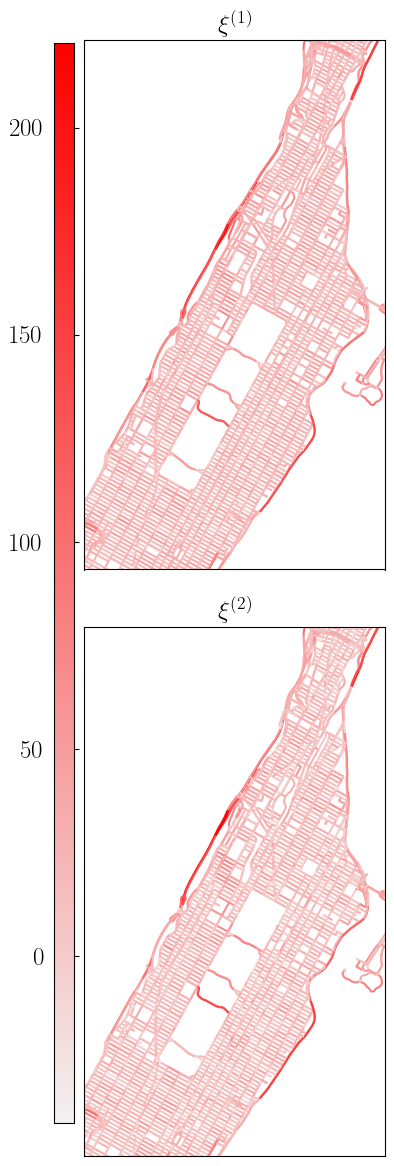

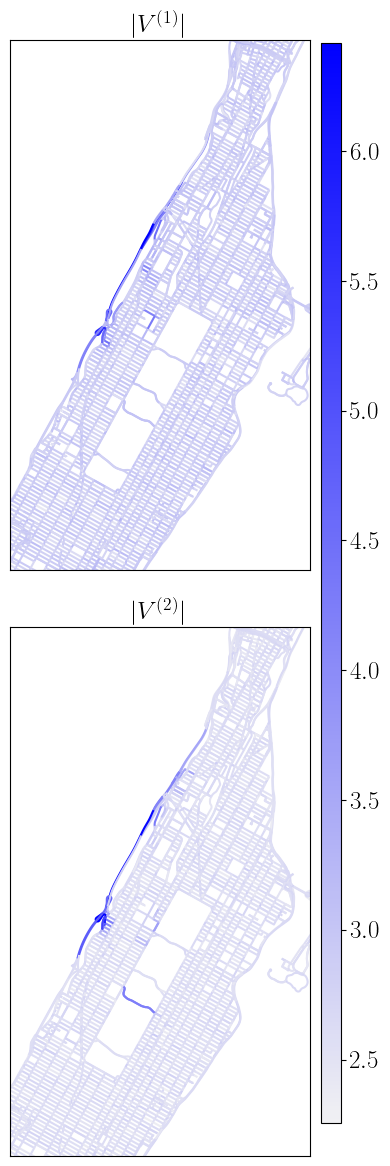

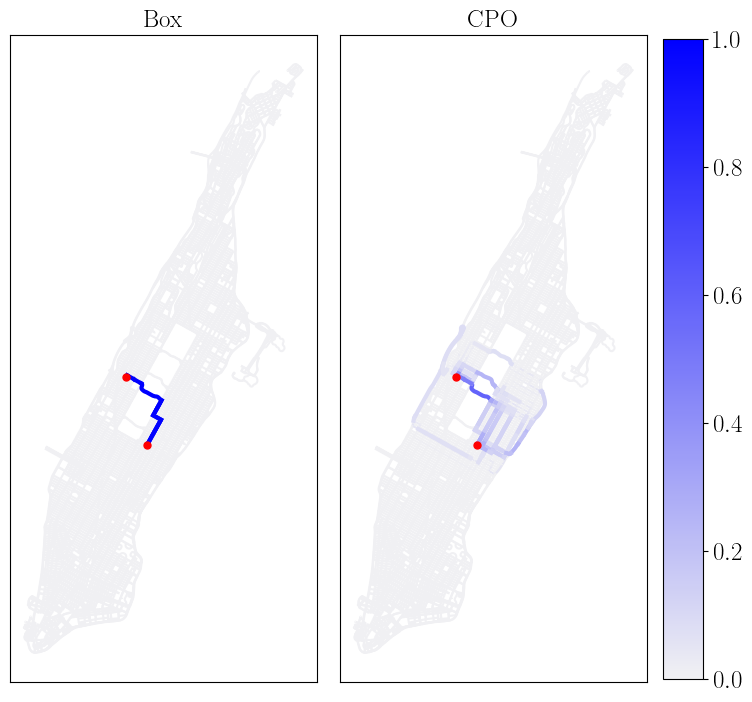

In [24]:
viz_attribute(regions_samples, position="left", cmap_name="light:r", titles=[r"$\xi^{(1)}$", r"$\xi^{(2)}$"], fn="temp_rps.png")
viz_attribute(cluster_rp_vars, position="right", cmap_name="light:b", titles=[r"$|V^{(1)}|$", r"$|V^{(2)}|$"], fn="temp_var.png")
viz_edge_weight_pair([box_edge_weights, ellipsoid_edge_weights], titles=["Box", "CPO"], fn="robust_traffic.png")

In [26]:
from PIL import Image

images = [Image.open(x) for x in ["temp_rps.png", "temp_var.png"]]
widths, heights = zip(*(i.size for i in images))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new("RGB", (total_width, max_height))

x_offset = 0
for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.save("weather_rps.png")